#### AFML - Sample simulation/AFM tests

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gudhi as gd
from scipy.interpolate import griddata
%matplotlib inline

import ripser
from persim import plot_diagrams

from AFML_functions import read_AFM_XYZ, read_XYZ, cut_out, plot_CG_2d, plot_CG_3d, order_z, unique_z, normalize_PC, remove_z_levels, plot_PC_2d, plot_PC_3d, mean_shift, smooth_terraces, interpolate_downsample, extract_dimensions

Looking to compare/contrast systems with different, distinct terrace shapes - LTA, l-cys, Para etc.

#### Paracetamol - AFM

In [2]:
afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_200.xyz')
rounded_afm = mean_shift(afm, bandwidth=0.00000475)
smooth_afm = smooth_terraces(rounded_afm, 0.1)
nearest_36 = interpolate_downsample(smooth_afm, 36, 'nearest')

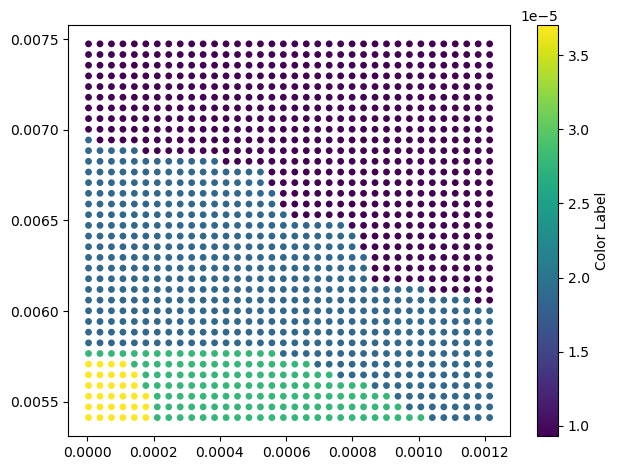

In [3]:
plot_PC_2d(nearest_36)

In [4]:
extract_dimensions(nearest_36)

{'length': 0.0012117038103774196,
 'width': 0.0020609366313237955,
 'height': 2.7744561994466938e-05}

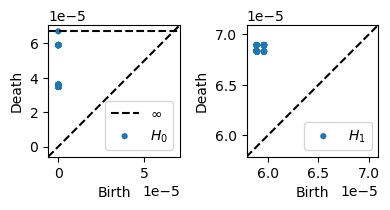

In [39]:
afm_dgms = ripser.ripser(nearest_36)['dgms']

plot_diagrams(afm_dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(afm_dgms, plot_only=[1], ax=plt.subplot(122))

#### Paracetamol - CG

In [6]:
crystal_edit = read_XYZ('/Users/user/Documents/PhD/AFML/test_sims/PAR_ETH_100_BIG/XYZ_files/PAR_ETH_100_1_ovito_CGvisualiser_unscaled.XYZ')
crystal_edit = order_z(crystal_edit)

In [19]:
crystal = remove_z_levels(crystal_edit, [6.,4.,2.])
crystal = crystal[:, 1:]

crystal = cut_out(crystal, 500, -150, 400)
#plot_PC_2d(crystal)
#print(crystal[:25])

In [8]:
extract_dimensions(crystal)

{'length': 397.791, 'width': 387.43399999999997, 'height': 23.298999999999978}

In [59]:
def voxelization(points, resolution):
    # Extract columns
    xs = points[:, 0]
    ys = points[:, 1]
    zs = points[:, 2]
    
    # Calculate voxel sizes based on resolution and the range of points in x and y
    x_voxel_size = (xs.max() - xs.min()) / resolution
    y_voxel_size = (ys.max() - ys.min()) / resolution
    
    # For voxelization, we'll floor-divide by voxel size and multiply again.
    # This will ensure points falling in the same voxel get the same coordinates.
    voxelized_xs = np.floor(xs / x_voxel_size) * x_voxel_size + x_voxel_size / 2
    voxelized_ys = np.floor(ys / y_voxel_size) * y_voxel_size + y_voxel_size / 2
    
    # Group by voxelized (X, Y) and Z, then calculate the mean for each group
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))
    
    # Now, for each voxel, we'll average the points (should be near identical due to voxelization)
    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])  # Z is preserved
        
    return np.array(centroids)

def voxelisation_expand_bound_half_offset(points, resolution):
    xs, ys, zs = points[:, 0], points[:, 1], points[:, 2]
    
    # Compute voxel size in x and y based on desired dimensions
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution

    # Expand boundaries by half a voxel size
    xs = xs + voxel_size_x / 2
    ys = ys + voxel_size_y / 2
    
    # Now, perform the voxelization using the adjusted coordinates
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2
    
    # Combine voxels based on average if they occupy the same position
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))

    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])
        
    return np.array(centroids)

def voxelisation_edge_fill(points, resolution):
    xs, ys, zs = points[:, 0], points[:, 1], points[:, 2]
    
    # Compute voxel size in x and y based on desired dimensions
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution
    
    # Voxelization
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2
    
    # Combine voxels based on average if they occupy the same position
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))

    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])

    # Edge filling
    filled_points = set()
    for pt in centroids:
        filled_points.add((pt[0], pt[1], pt[2]))
    
    min_x, min_y, max_x, max_y = xs.min(), ys.min(), xs.max(), ys.max()
    z_levels = sorted(set(zs))

    # Loop over all possible edge voxels and fill if they're empty
    for z in z_levels:
        for x in [min_x, max_x]:
            for y in np.arange(min_y, max_y + voxel_size_y, voxel_size_y):
                if (x, y, z) not in filled_points:
                    centroids.append([x, y, z])
        for y in [min_y, max_y]:
            for x in np.arange(min_x, max_x + voxel_size_x, voxel_size_x):
                if (x, y, z) not in filled_points:
                    centroids.append([x, y, z])

    return np.array(centroids)

def voxelisation_edge_fill_z(points, resolution):
    xs, ys, zs = points[:, 0], points[:, 1], points[:, 2]
    
    # Compute voxel size in x and y based on desired dimensions
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution
    
    # Voxelization
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2
    
    # Combine voxels based on average if they occupy the same position
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))

    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])

    filled_points = set()
    for pt in centroids:
        filled_points.add((pt[0], pt[1], pt[2]))

    z_levels = sorted(set(zs))
    min_x, max_x = xs.min(), xs.max()
    min_y, max_y = ys.min(), ys.max()

    # Check the boundaries for each z-level
    for z in z_levels:
        # Check in X direction
        for y in np.arange(min_y, max_y + voxel_size_y, voxel_size_y):
            for x in [min_x, max_x]:
                if (x, y, z) not in filled_points:
                    # Check if adjacent voxels exist
                    neighbors = [(x + voxel_size_x, y, z), (x - voxel_size_x, y, z)]
                    if any(neighbor in filled_points for neighbor in neighbors):
                        centroids.append([x, y, z])

        # Check in Y direction
        for x in np.arange(min_x, max_x + voxel_size_x, voxel_size_x):
            for y in [min_y, max_y]:
                if (x, y, z) not in filled_points:
                    # Check if adjacent voxels exist
                    neighbors = [(x, y + voxel_size_y, z), (x, y - voxel_size_y, z)]
                    if any(neighbor in filled_points for neighbor in neighbors):
                        centroids.append([x, y, z])

    return np.array(centroids)

def voxelisation_boundary_fill(points, resolution):
    xs = points[:, 0]
    ys = points[:, 1]
    zs = points[:, 2]

    # Compute voxel size
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution

    # Voxel assignment
    voxelized_xs = (xs / voxel_size_x).astype(int) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = (ys / voxel_size_y).astype(int) * voxel_size_y + voxel_size_y / 2

    voxelized_points = np.array(list(zip(voxelized_xs, voxelized_ys, zs)))

    # Process by unique z-levels
    unique_z_levels = np.unique(zs)
    all_filled_points = []
    for z_level in unique_z_levels:
        z_points = voxelized_points[voxelized_points[:, 2] == z_level]

        # Check boundary cells and fill
        for x in [xs.min(), xs.max() - voxel_size_x]:  # left and right boundaries
            for y in np.arange(ys.min(), ys.max(), voxel_size_y):
                if not any((z_points[:, 0] == x) & (z_points[:, 1] == y)):
                    # Check neighbors
                    neighbors = [[x + voxel_size_x, y], [x - voxel_size_x, y], [x, y + voxel_size_y], [x, y - voxel_size_y]]
                    for nx, ny in neighbors:
                        if any((z_points[:, 0] == nx) & (z_points[:, 1] == ny)):
                            z_points = np.vstack([z_points, [x, y, z_level]])
                            break  # Only add one point per missing boundary voxel

        for y in [ys.min(), ys.max() - voxel_size_y]:  # top and bottom boundaries
            for x in np.arange(xs.min(), xs.max(), voxel_size_x):
                if not any((z_points[:, 0] == x) & (z_points[:, 1] == y)):
                    # Check neighbors
                    neighbors = [[x, y + voxel_size_y], [x, y - voxel_size_y], [x + voxel_size_x, y], [x - voxel_size_x, y]]
                    for nx, ny in neighbors:
                        if any((z_points[:, 0] == nx) & (z_points[:, 1] == ny)):
                            z_points = np.vstack([z_points, [x, y, z_level]])
                            break  # Only add one point per missing boundary voxel

        all_filled_points.append(z_points)

    return np.vstack(all_filled_points)

def voxelization_with_boundary_fill(points, resolution):
    # Extract columns
    xs = points[:, 0]
    ys = points[:, 1]
    zs = points[:, 2]
    
    # Compute voxel sizes
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution

    # Voxelization
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2

    # Convert to voxel coordinates (this will help us identify neighbors easily)
    voxel_coords = np.column_stack([
        (voxelized_xs - xs.min()) / voxel_size_x,
        (voxelized_ys - ys.min()) / voxel_size_y,
        zs
    ]).astype(int)

    # Convert to a dictionary for quick membership checking
    voxel_dict = {(x, y, z) for x, y, z in voxel_coords}

    # Function to check if a voxel exists in our set
    def voxel_exists(x, y, z):
        return (x, y, z) in voxel_dict

    # Boundary fill
    for z in np.unique(zs):
        for x in range(resolution):
            for y in [0, resolution - 1]:  # top and bottom boundaries
                if not voxel_exists(x, y, int(z)):
                    # Check neighbors (in the Y direction since we're at top/bottom boundaries)
                    if voxel_exists(x, y-1, int(z)) or voxel_exists(x, y+1, int(z)):
                        voxel_dict.add((x, y, int(z)))

        for y in range(resolution):
            for x in [0, resolution - 1]:  # left and right boundaries
                if not voxel_exists(x, y, int(z)):
                    # Check neighbors (in the X direction since we're at left/right boundaries)
                    if voxel_exists(x-1, y, int(z)) or voxel_exists(x+1, y, int(z)):
                        voxel_dict.add((x, y, int(z)))

    # Convert back to original coordinates for the result
    filled_voxels = np.array([[x * voxel_size_x + xs.min(), 
                               y * voxel_size_y + ys.min(), 
                               z] for x, y, z in voxel_dict])

    return filled_voxels

def fill_boundary_voxels(voxelized_data, resolution):
    # Extracted voxel sizes based on desired resolution and point cloud dimensions
    x_min, x_max = np.min(voxelized_data[:, 0]), np.max(voxelized_data[:, 0])
    y_min, y_max = np.min(voxelized_data[:, 1]), np.max(voxelized_data[:, 1])
    z_min, z_max = np.min(voxelized_data[:, 2]), np.max(voxelized_data[:, 2])
    
    voxel_size_x = (x_max - x_min) / resolution
    voxel_size_y = (y_max - y_min) / resolution

    # Set to quickly check existence of a voxel
    voxel_set = set(map(tuple, voxelized_data))

    # Check the x boundaries
    for y in np.arange(y_min, y_max + voxel_size_y, voxel_size_y):
        for z in np.arange(z_min, z_max + 1):
            if (x_min, y, z) not in voxel_set:
                voxel_set.add((x_min, y, z))
            if (x_max, y, z) not in voxel_set:
                voxel_set.add((x_max, y, z))

    # Check the y boundaries
    for x in np.arange(x_min, x_max + voxel_size_x, voxel_size_x):
        for z in np.arange(z_min, z_max + 1):
            if (x, y_min, z) not in voxel_set:
                voxel_set.add((x, y_min, z))
            if (x, y_max, z) not in voxel_set:
                voxel_set.add((x, y_max, z))

    # Convert set back to array
    filled_data = np.array(list(voxel_set))

    return filled_data

def adjacent_z_wipe(voxelized_points):
    """
    For voxels with the same (x, y) but adjacent z-levels, remove the one at the lower z-level.
    """
    
    # Create a dictionary to track voxel positions
    voxel_dict = {(x, y): z for x, y, z in voxelized_points}
    
    # Iterate over the voxelized_points to identify conflicts
    to_remove = set()
    for x, y, z in voxelized_points:
        if (x, y, z + 1) in voxel_dict:  # Check if there's a voxel directly above the current voxel
            to_remove.add((x, y, z))
    
    # Remove the identified conflicting points
    cleaned_points = np.array([point for point in voxelized_points if (point[0], point[1], point[2]) not in to_remove])
    
    return cleaned_points




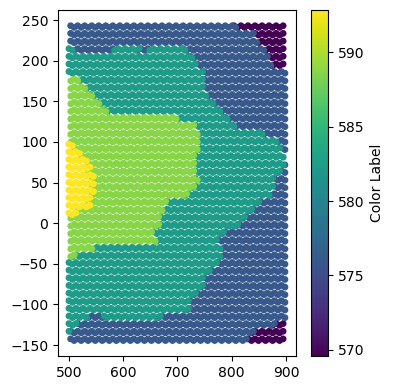

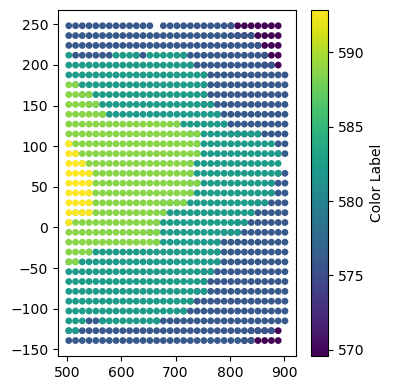

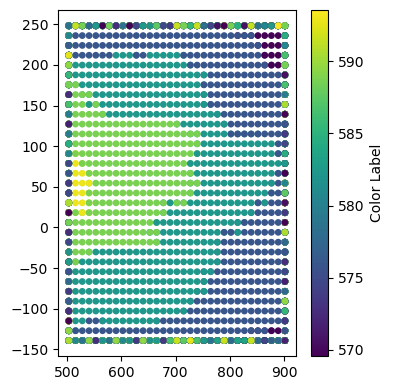

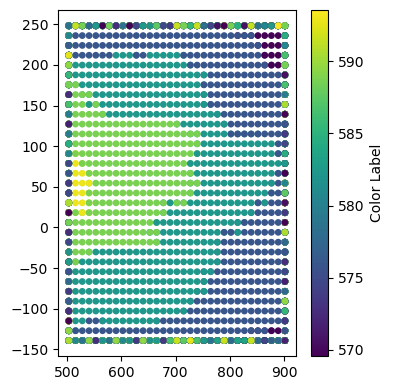

In [61]:
crystal_voxel32 = voxelization(crystal, 32)
#crystal_voxel32_2 = voxelisation_expand_bound_half_offset(crystal, 32)
#crystal_voxel32_4 = voxelisation_edge_fill_z(crystal, 32)
#crystal_voxel32_3 = voxelisation_edge_fill(crystal, 32)
#crystal_voxel32_5 = voxelisation_boundary_fill(crystal, 32)
#crystal_voxel32_6 = voxelization_with_boundary_fill(crystal, 32)

crystal_voxel32boundary = fill_boundary_voxels(crystal_voxel32, 32)

crystal_voxel32wipe = adjacent_z_wipe(crystal_voxel32boundary)

plot_PC_2d(crystal)
plot_PC_2d(crystal_voxel32)
#plot_PC_2d(crystal_voxel32boundary)
#plot_PC_2d(crystal_voxel32wipe)

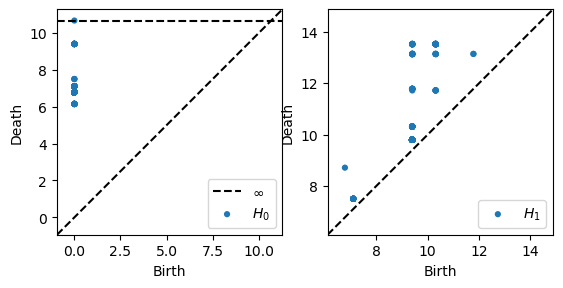

In [47]:
CG_dgms = ripser.ripser(crystal)['dgms']

plot_diagrams(CG_dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(CG_dgms, plot_only=[1], ax=plt.subplot(122))

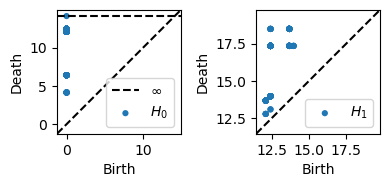

In [46]:
CG_dgms_voxel = ripser.ripser(crystal_voxel32wipe)['dgms']

plot_diagrams(CG_dgms_voxel, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(CG_dgms_voxel, plot_only=[1], ax=plt.subplot(122))